In [0]:
import numpy as np
import tensorflow as tf
from collections import defaultdict
from skimage import io
from keras import layers
from keras.layers import Dropout, Input, concatenate
from keras import models
from keras.models import Model, load_model
from keras import backend as K
from keras.applications import ResNet50
from keras import models
from keras.models import Model, Sequential
from keras.layers import Dropout
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import unique_labels
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from keras.applications import ResNet50
from keras.callbacks import ModelCheckpoint

# Loss function

In [0]:
def triplet_loss(y_true, y_pred):
  del y_true

  total_lenght = y_pred.shape.as_list()[-1]   
   
  anchor = y_pred[:,0:int(total_lenght*1/3)]
  positive = y_pred[:,int(total_lenght*1/3):int(total_lenght*2/3)]
  negative = y_pred[:,int(total_lenght*2/3):int(total_lenght*3/3)]

  dist = "qeuclidean"
  margin = "softplus"

  positive_distance = K.square(anchor - positive)
  negative_distance = K.square(anchor - negative)
  if dist == "sqeuclidean":
    positive_distance = K.mean(positive_distance, axis=-1, keepdims=True)
    negative_distance = K.mean(negative_distance, axis=-1, keepdims=True)
  elif dist == "qeuclidean":
    positive_distance = tf.math.sqrt(K.sum(positive_distance, axis=-1, keepdims=True))
    negative_distance = tf.math.sqrt(K.sum(negative_distance, axis=-1, keepdims=True))
  loss = positive_distance - negative_distance
  if margin == "maxplus":
    loss = K.maximum(0.0, 1+loss)
  elif margin == 'softplus':
    loss = K.log(1 + K.exp(loss))

  return K.mean(loss)

# Accuracy function

In [0]:
def accuracy(y_true, y_pred):
  del y_true

  total_lenght = y_pred.shape.as_list()[-1]  

  anchor = y_pred[:,0:int(total_lenght*1/3)]
  positive = y_pred[:,int(total_lenght*1/3):int(total_lenght*2/3)]
  negative = y_pred[:,int(total_lenght*2/3):int(total_lenght*3/3)]
  
  positive_distance = K.square(anchor - positive)
  negative_distance = K.square(anchor - negative)
  positive_distance = tf.math.sqrt(K.sum(positive_distance, axis=-1, keepdims=True))
  negative_distance = tf.math.sqrt(K.sum(negative_distance, axis=-1, keepdims=True))
    
  return K.mean(positive_distance < negative_distance)

# Embedding model

In [0]:
def embedding_model_function(input_shape):

  base_input = Input(input_shape)
  x1 = layers.Conv2D(128, (3, 3), activation='relu')(base_input)
  x1 = layers.MaxPooling2D((2, 2))(x1)
  x1 = layers.Conv2D(128, (3, 3), activation='relu')(x1)
  x1 = layers.MaxPooling2D((2, 2))(x1)
  x1 = layers.Conv2D(128, (3, 3), activation='relu')(x1)
  x1 = layers.MaxPooling2D((2, 2))(x1)
  x1 = layers.Conv2D(128, (3, 3), activation='relu')(x1)
  x1 = layers.MaxPooling2D((2, 2))(x1)
  x1 = layers.Dropout(0.25)(x1)
  x1 = layers.Flatten()(x1)
  x1 = layers.Dense(64, activation='linear')(x1)
  embedding_model = Model(base_input, x1, name='embedding')

  return embedding_model

In [80]:
embedding_model = embedding_model_function((224, 224, 3))
embedding_model.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 222, 222, 128)     3584      
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 111, 111, 128)     0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 109, 109, 128)     147584    
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 54, 54, 128)       0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 52, 52, 128)       147584    
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 26, 26, 128)       0 

# Triplet model

In [0]:
def triplet_model_function(embedding_model, input_shape):
  anchor_input = Input(input_shape, name='anchor_input')
  positive_input = Input(input_shape, name='positive_input')
  negative_input = Input(input_shape, name='negative_input')
    
  anchor_embedding = embedding_model(anchor_input)
  positive_embedding = embedding_model(positive_input)
  negative_embedding = embedding_model(negative_input)

  inputs = [anchor_input, positive_input, negative_input]
  merged_vector = concatenate([anchor_embedding, positive_embedding, negative_embedding], axis=-1, name='merged_layer')

  triplet_model = Model(inputs=inputs, outputs=merged_vector)

  return triplet_model

# Functions for triplets generation (faseScrub)

In [0]:
def get_triples_indices(grouped, n):
    num_classes = len(grouped)
    list_labels = list(grouped.keys())
    list_labels_copy = list_labels.copy()
    for label in list_labels_copy:
      if len(grouped[label]) < 2:
        list_labels.remove(label)
    pairs = []
    for i in range(0,n,1):
        pairs.append(np.random.choice(list_labels, size=2, replace = False))
    pairs = np.array(pairs)
    positive_labels = pairs[:,0]
    negative_labels = pairs[:,1]
    triples_indices = []
    for positive_label, negative_label in zip(positive_labels, negative_labels):
        negative = np.random.choice(grouped[negative_label])
        positive_group = grouped[positive_label]
        m = len(positive_group)
        anchor_j = np.random.randint(0, m)
        anchor = positive_group[anchor_j]
        positive_j = (np.random.randint(1, m) + anchor_j) % m
        positive = positive_group[positive_j]
        triples_indices.append([anchor, positive, negative])
    return np.asarray(triples_indices)

def get_triples_data(x, grouped, n, image_path):
    indices = get_triples_indices(grouped, n)
    x1,x2,x3 = [],[],[]
    for i in indices[:,0]:
      x1.append(io.imread(image_path + "/" + str(x[i]) + ".jpg"))
    for i in indices[:,1]:
      x2.append(io.imread(image_path + "/" + str(x[i]) + ".jpg"))
    for i in indices[:,2]:
      x3.append(io.imread(image_path + "/" + str(x[i]) + ".jpg"))
    x1 = np.array(x1)
    x2 = np.array(x2)
    x3 = np.array(x3)
    return x1/255, x2/255, x3/255
    
def triplet_generator(x, y, batch_size, image_path):
    grouped = defaultdict(list)
    for i, label in enumerate(y):
        grouped[label].append(i)
       
    while True:
        x_anchor, x_positive, x_negative = get_triples_data(x, grouped, batch_size, image_path)
        yield ({'anchor_input': x_anchor,
               'positive_input': x_positive,
               'negative_input': x_negative},
               np.zeros(len(x_anchor)))

# Reading metadata

In [0]:
!cp -a "/content/drive/My Drive/Colab/Roonyx/Face recognition/faceScrub/croped_images_224" "/content/croped_images_224"
!cp -a "/content/drive/My Drive/Colab/Roonyx/Face recognition/faceScrub/metadata/metadata_small.npz" "/content/metadata_small.npz"

In [0]:
readed = np.load('/content/metadata_small.npz')
metadata = readed["metadata_small"]
x = metadata[:,0]
x = np.array(x, dtype='int64')
y = metadata[:,1]
y = np.array(y, dtype='int64')
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=0)

# Model training

In [26]:
embedding_model = embedding_model_function(input_shape = (224, 224, 3))
triplet_model = triplet_model_function(embedding_model, input_shape = (224, 224, 3))
triplet_model.compile(loss=triplet_loss, optimizer="adam", metrics = [accuracy])

batch_size = 20
image_path = "/content/croped_images_224"

checkpoint = ModelCheckpoint(filepath = '/content/drive/My Drive/Colab/Roonyx/Face recognition/06.06.2020/BEST_RESULTS',
                             monitor='val_accuracy',
                             verbose=0,
                             save_best_only=True,
                             mode='auto',
                             period=1)

history = triplet_model.fit_generator(triplet_generator(X_train, y_train, batch_size, image_path),
                                      steps_per_epoch=20,
                                      epochs=70,
                                      validation_data=triplet_generator(X_test, y_test, batch_size, image_path),
                                      validation_steps = 20,
                                      verbose=1,
                                      callbacks=[checkpoint])

Epoch 1/70
20/20 [==============================] - 11s 526ms/step - loss: 0.6606 - accuracy: 0.5825 - val_loss: 0.4806 - val_accuracy: 0.6250
Epoch 2/70
20/20 [==============================] - 9s 429ms/step - loss: 0.6268 - accuracy: 0.6800 - val_loss: 0.6550 - val_accuracy: 0.6525
Epoch 3/70
20/20 [==============================] - 8s 424ms/step - loss: 0.6015 - accuracy: 0.6600 - val_loss: 0.4726 - val_accuracy: 0.7075
Epoch 4/70
20/20 [==============================] - 8s 421ms/step - loss: 0.5053 - accuracy: 0.7350 - val_loss: 0.4092 - val_accuracy: 0.7200
Epoch 5/70
20/20 [==============================] - 8s 418ms/step - loss: 0.4560 - accuracy: 0.7500 - val_loss: 0.3733 - val_accuracy: 0.7875
Epoch 6/70
20/20 [==============================] - 8s 417ms/step - loss: 0.3827 - accuracy: 0.8000 - val_loss: 0.4005 - val_accuracy: 0.7125
Epoch 7/70
20/20 [==============================] - 8s 414ms/step - loss: 0.3973 - accuracy: 0.8200 - val_loss: 0.6832 - val_accuracy: 0.7975
Epoch

# Model loss and accuracy

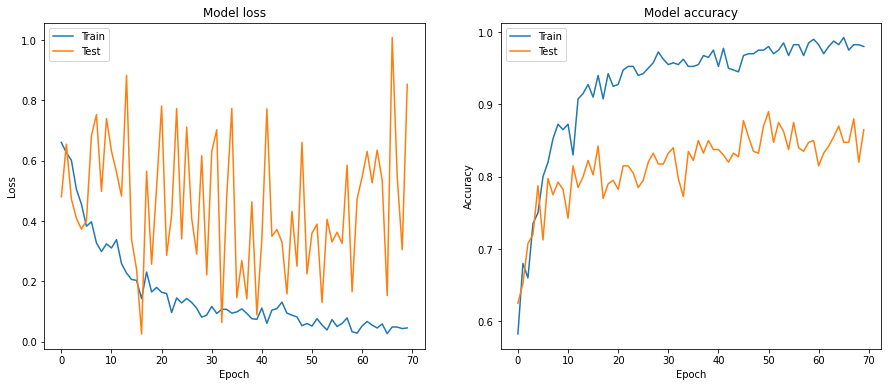

In [27]:
plt.figure(figsize=(15,6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

In [0]:
# triplet_model.save("/content/drive/My Drive/Colab/Roonyx/Face recognition/07.06.2020/" + 'MODEL_triplet.h5')
# embedding_model.save("/content/drive/My Drive/Colab/Roonyx/Face recognition/07.06.2020/" + 'MODEL_embedding.h5')

# Load saved encoder

In [0]:
embedding_model = load_model('/content/drive/My Drive/Colab/Roonyx/Face recognition/07.06.2020/MODEL_embedding.h5')

# Example of prediction

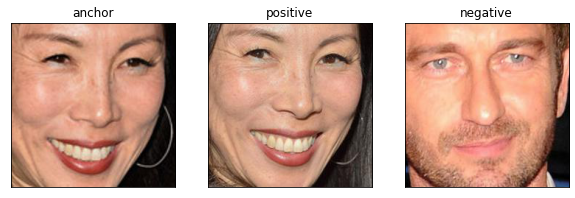

In [95]:
image_path = "/content/croped_images_224"
data = triplet_generator(X_test,y_test,1,image_path)

for item in data:
  triplet = item
  break

anchor = triplet[0]["anchor_input"]
positive = triplet[0]["positive_input"]
negative = triplet[0]["negative_input"]

images = [anchor[0], positive[0], negative[0]]
names = ["anchor", "positive", "negative"]
fix,axes = plt.subplots(1,3, figsize=(10,4), subplot_kw={'xticks':(),'yticks':()})
for name, image, ax in zip(names, images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(name)

In [96]:
embedding_anchor = embedding_model.predict(anchor)
embedding_positive = embedding_model.predict(positive)
embedding_negative = embedding_model.predict(negative)

positive_distance = np.sum((embedding_anchor[0] - embedding_positive[0])**2)
negative_distance = np.sum((embedding_anchor[0] - embedding_negative[0])**2)

print("Distance anchor-positive: ", positive_distance)
print("Distance anchor-negative: ", negative_distance)
if positive_distance < negative_distance:
  print("True!")
else: print("False")

Distance anchor-positive:  81.82193
Distance anchor-negative:  407.9256
True!


# Test model on 1000 triplets generated with test data

In [36]:
image_path = "/content/croped_images_224"
data = triplet_generator(X_test,y_test,1,image_path)
triplets = []
num = 0
for item in data:
  triplets.append(item)
  num+=1
  if num==1000:
    break

num_true = 0
num_false = 0

for i in range(0,1000,1):

  anchor = triplets[i][0]["anchor_input"]
  positive = triplets[i][0]["positive_input"]
  negative = triplets[i][0]["negative_input"]

  embedding_anchor = embedding_model.predict(anchor)
  embedding_positive = embedding_model.predict(positive)
  embedding_negative = embedding_model.predict(negative)

  positive_distance = np.sum((embedding_anchor[0] - embedding_positive[0])**2)
  negative_distance = np.sum((embedding_anchor[0] - embedding_negative[0])**2)

  if positive_distance < negative_distance:
    num_true+=1
  else: num_false+=1

print("num true: ", num_true)
print("num false: ", num_false)
print("Accuracy: {:.2f}%".format(num_true/((num_true+num_false)/100)))

num true:  857
num false:  143
Accuracy: 85.70%


# Calculation of model operating time

In [97]:
%%time
embedding_anchor = embedding_model.predict(anchor)

CPU times: user 6.01 ms, sys: 0 ns, total: 6.01 ms
Wall time: 7.73 ms
